In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import torch
import whisper
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score


In [2]:
def normalize_lang(label):
    return label.split("-")[0].lower()

DATA_DIR = "minds14_lid"
AUDIO_DIR = os.path.join(DATA_DIR, "audio")

test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
test_df["norm_lang"] = test_df["language"].apply(normalize_lang)

# 🔥 fixed subset for ALL models
subset_df = test_df.sample(n=100, random_state=42).reset_index(drop=True)

print("Subset size:", len(subset_df))
print(subset_df["norm_lang"].value_counts())


Subset size: 100
norm_lang
de    12
pt    12
pl    11
fr    11
ko    10
zh     8
ru     8
it     8
en     8
nl     7
es     5
Name: count, dtype: int64


In [3]:
def extract_mfcc(path, n_mfcc=13):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)


In [4]:
X, y = [], []

for _, row in subset_df.iterrows():
    audio_path = os.path.join(AUDIO_DIR, row["filename"])
    X.append(extract_mfcc(audio_path))
    y.append(row["norm_lang"])

X = np.array(X)
y = np.array(y)

le = LabelEncoder()
y_true = le.fit_transform(y)

print("Classes:", le.classes_)


Classes: ['de' 'en' 'es' 'fr' 'it' 'ko' 'nl' 'pl' 'pt' 'ru' 'zh']


In [5]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X, y_true)

y_pred_lr = lr.predict(X)


C:\Users\Lenovo\anaconda3\envs\lid\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
svm = SVC(kernel="rbf")
svm.fit(X, y_true)

y_pred_svm = svm.predict(X)


In [7]:
whisper_model = whisper.load_model("tiny")

y_true_wh, y_pred_wh = [], []

for _, row in subset_df.iterrows():
    audio_path = os.path.join(AUDIO_DIR, row["filename"])

    audio, sr = sf.read(audio_path)

    if audio.ndim > 1:
        audio = audio.mean(axis=1)

    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

    audio = audio.astype(np.float32)

    # 🔥 only first 5 seconds
    audio = audio[:16000 * 5]
    audio = whisper.pad_or_trim(audio)

    mel = whisper.log_mel_spectrogram(audio).to(whisper_model.device)

    with torch.no_grad():
        _, probs = whisper_model.detect_language(mel)

    pred_lang = max(probs, key=probs.get)

    if pred_lang in le.classes_:
        y_pred_wh.append(np.where(le.classes_ == pred_lang)[0][0])
        y_true_wh.append(np.where(le.classes_ == row["norm_lang"])[0][0])


C:\Users\Lenovo\anaconda3\envs\lid\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
results = {
    "MFCC + Logistic Regression": {
        "accuracy": accuracy_score(y_true, y_pred_lr),
        "macro_f1": f1_score(y_true, y_pred_lr, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred_lr, average="weighted"),
    },
    "MFCC + SVM": {
        "accuracy": accuracy_score(y_true, y_pred_svm),
        "macro_f1": f1_score(y_true, y_pred_svm, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred_svm, average="weighted"),
    },
    "Whisper (tiny)": {
        "accuracy": accuracy_score(y_true_wh, y_pred_wh),
        "macro_f1": f1_score(y_true_wh, y_pred_wh, average="macro"),
        "weighted_f1": f1_score(y_true_wh, y_pred_wh, average="weighted"),
    }
}

results_df = pd.DataFrame(results).T
print(results_df)


                            accuracy  macro_f1  weighted_f1
MFCC + Logistic Regression  0.580000  0.593542     0.575415
MFCC + SVM                  0.140000  0.045221     0.057026
Whisper (tiny)              0.808511  0.776623     0.794340


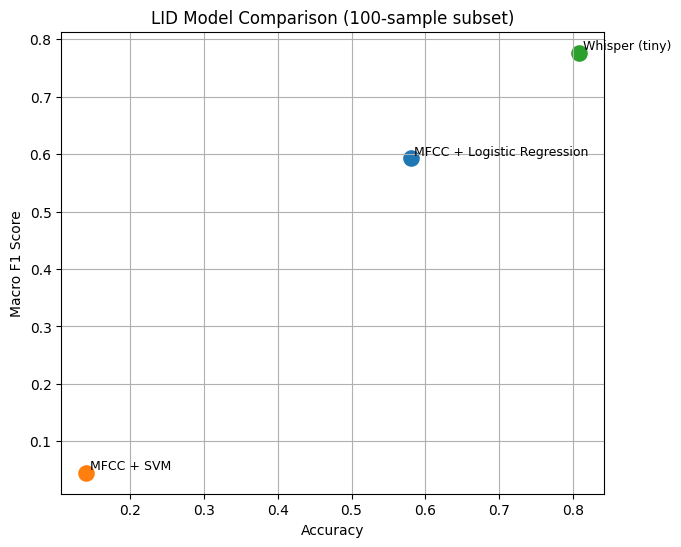

In [9]:
plt.figure(figsize=(7, 6))

for model, row in results_df.iterrows():
    plt.scatter(row["accuracy"], row["macro_f1"], s=120)
    plt.text(
        row["accuracy"] + 0.005,
        row["macro_f1"] + 0.005,
        model,
        fontsize=9
    )

plt.xlabel("Accuracy")
plt.ylabel("Macro F1 Score")
plt.title("LID Model Comparison (100-sample subset)")
plt.grid(True)
plt.show()


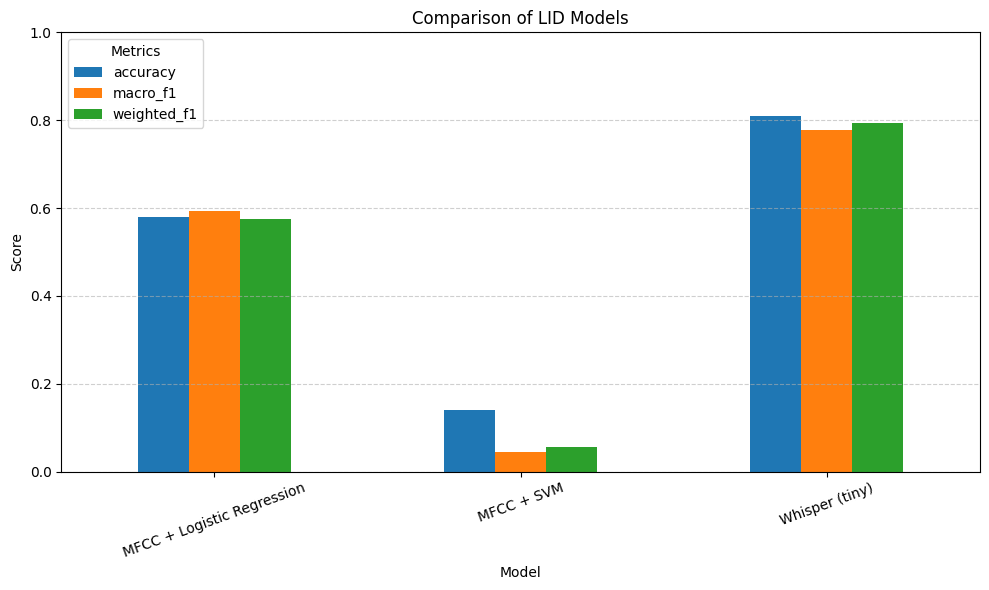

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

results_df.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Comparison of LID Models")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.legend(title="Metrics")
plt.tight_layout()
plt.show()
